# Описание проекта: промышленность(Прогнозирование температуры сплава)

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

# Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- **data_arc_new.csv** — данные об электродах;
- **data_bulk_new.csv** — данные о подаче сыпучих материалов (объём);
- **data_bulk_time_new.csv** — данные о подаче сыпучих материалов (время);
- **data_gas_new.csv** — данные о продувке сплава газом;
- **data_temp_new.csv** — результаты измерения температуры;
- **data_wire_new.csv** — данные о проволочных материалах (объём);
- **data_wire_time_new.csv** — данные о проволочных материалах (время).

Во всех файлах столбец **key** содержит номер партии. В файлах может быть несколько строк с одинаковым значением **key**: они соответствуют разным итерациям обработки.

# План выполнения проекта

1 **Первичный анализ данных**

- Импорт библиотек

- чтение файлов

- изучение данных

- построение граффиков

- поиск дубликатов

- поиск взаимосвязей

- написание промежуточных выводов

2 **Подготовка данных к обучению модели**

- Обработка пропусков

- очистка данных

- формирование таблиц признаков

- формирование выборок

3 **Построение модели** Рассмотрим несколько вариантов моделей ML

- Линейная регрессия

- Дерево решений

- Случайный лес

- CatBoost


4 **Тестирование модели**

- Тестирование модели

- Проверка модели на адекватность

- Оценка важности признаков

5 **Отчёт о проделанной работе**

- Написание общего вывода о проделанной работе

## Первичный анализ данных

Импортируем бибилотеки

Преобразуем данные о дате и времени к типу **Datetime**

Напишем функцию для избежания дублирования кода

In [1]:
# Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

In [2]:
# список колонок сыпучищ и прволочных добавок
bulks = ['Bulk '+ str(i) for i in range(1,16)]
wires = ['Wire '+ str(i) for i in range(1,10)]

#Загрузка данных

df_arc=pd.read_csv('/datasets/data_arc_new.csv',parse_dates=['Начало нагрева дугой','Конец нагрева дугой'])
df_bulk=pd.read_csv('/datasets/data_bulk_new.csv')
df_bulk_time=pd.read_csv('/datasets/data_bulk_time_new.csv',parse_dates=bulks)
df_gas=pd.read_csv('/datasets/data_gas_new.csv')
df_temp=pd.read_csv('/datasets/data_temp_new.csv',parse_dates=['Время замера'])
df_wire=pd.read_csv('/datasets/data_wire_new.csv')
df_wire_time=pd.read_csv('/datasets/data_wire_time_new.csv',parse_dates=wires)

In [3]:
# функция для избежания дублирования кода о датафрейме

def info(df):
    display(df.head())
    display(df.info())
    display(df.describe())
    print('Количество дубликатов: ', df.duplicated().sum())
    print('Количество уникальных партий: ', len(df['key'].unique()))
    # Матрица
    size = len(df.columns)
    plt.figure(figsize=(size,size/2))
    df = df.drop('key', axis=1)
    try:
        corr_matrix = sns.heatmap(df.corr(),annot=True)
        corr_matrix.axes.set_title('Матрица кореляции', fontsize=16)
        plt.show()
    except:
        print()

### Анализ данных сплава нагрева электродами

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


None

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


Количество дубликатов:  0
Количество уникальных партий:  3214


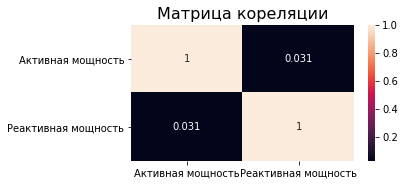

In [4]:
info(df_arc)

Какой либо сильной линейной зависимости не наблюдается

Значение в **-715.479924** в столбце **реактивная мощность** явно выглядит как аномалия

Для детального анализа сформируем признаки **Время нагрева**,**Полная мощнасть**,**Энергия нагрева**

In [5]:
# Формирование признаков

df_arc['Время нагрева'] = (df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой']).astype('int64') / 1000000000
df_arc['Полная мощность'] = np.sqrt(df_arc['Активная мощность']**2 + df_arc['Реактивная мощность']**2)
df_arc['Энергия нагрева'] = df_arc['Полная мощность'] * df_arc['Время нагрева']

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева,Полная мощность,Энергия нагрева
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,0.371123,84.616003
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,0.902319,166.928978
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,0.722536,124.276277
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,0.642824,234.630603
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,1.079934,159.830252


<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14875 non-null  int64         
 1   Начало нагрева дугой  14875 non-null  datetime64[ns]
 2   Конец нагрева дугой   14875 non-null  datetime64[ns]
 3   Активная мощность     14875 non-null  float64       
 4   Реактивная мощность   14875 non-null  float64       
 5   Время нагрева         14875 non-null  float64       
 6   Полная мощность       14875 non-null  float64       
 7   Энергия нагрева       14875 non-null  float64       
dtypes: datetime64[ns](2), float64(5), int64(1)
memory usage: 1.0 MB


None

,key,Активная мощность,Реактивная мощность,Время нагрева,Полная мощность,Энергия нагрева
count,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000
mean,1615.186756,0.662749,0.487115,171.675160,0.823385,141.646999
std,934.593897,0.258894,0.197612,98.188759,0.323470,103.200377
min,1.000000,0.223120,0.153777,11.000000,0.275718,6.409531
25%,806.000000,0.467115,0.337190,107.000000,0.578839,71.153177
50%,1617.000000,0.599578,0.441665,147.000000,0.746554,114.480842
75%,2429.000000,0.830135,0.608223,214.000000,1.030402,181.350568
max,3241.000000,1.463773,1.270284,907.000000,1.898158,1084.729420


Количество дубликатов:  0
Количество уникальных партий:  3214


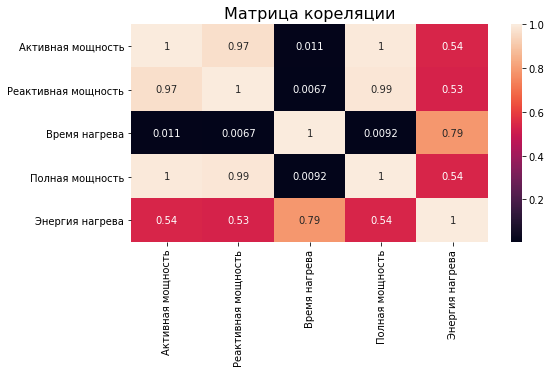

In [6]:
info(df_arc[df_arc['Реактивная мощность']> - 700])

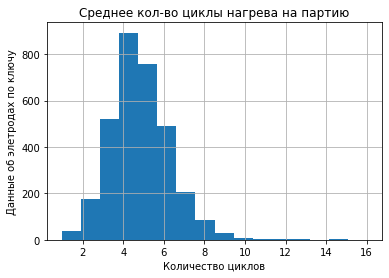

In [7]:
# Цмклы нагрева 1 партии
df_arc['key'].value_counts().sort_values().hist(bins=16)
plt.title('Среднее кол-во циклы нагрева на партию')
plt.xlabel('Количество циклов')
plt.ylabel('Данные об элетродах по ключу')
plt.show()

**Вывов по Нагреву электродами'** 

- Были рассчитаны и созданы признаки  **Время нагрева**,**Полная мощнасть**,**Время нагрева**

- Обнаруженно аномальное значение в **-715.479924**, при повторном построение матрицы данное значение не вносилу в таблицу и матрицу

- Пропуски и дублиекаты отсутвуют 

- Между признаками наблюдается корелляция (где то слабее,где то сильнее)

- Медианное кол-во циклов нагрева 4 максимальное 16

- Если будем использовать для модели данные о энергии нагрева,то избавимся от мультикорелиарности

### Анализ данных о подаче сыпучих материалов

Так данные о сыпучих материалов деляться на на **объём** и **время**,проанализируем обе табилцы последовательно

**Объём**

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Количество дубликатов:  0
Количество уникальных партий:  3129


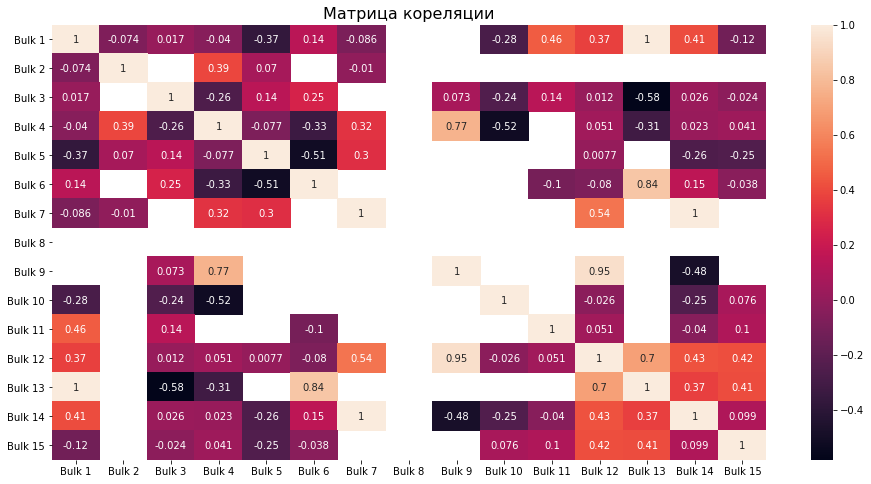

In [8]:
info(df_bulk)

In [9]:
# Cреднее добавление материалов в каждую партию 
df_bulk.drop('key', axis=1).notna().sum().sum() / df_bulk.shape[0]

3.5663151166506872

In [10]:
info(df_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


None

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Количество дубликатов:  0
Количество уникальных партий:  3129



<Figure size 1152x576 with 0 Axes>

**Общий вывод по сыпучим материалам**

- Дубликаты отсутвуют

- Пропуски скорее всего говорят о том,что в данную партию не добавлялся сыпучий материал,следовательно пропуски можно заполнить нулями

- На матрицы корелляции можно отметить что в **Bulk 1** подают вместе с **Bulk 13**, a **Bulk 7** вместе с **Bulk 14**

- Cреднее добавление материалов в каждую партию 3.56

### Анализ данных о продувке сплава газом

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Количество дубликатов:  0
Количество уникальных партий:  3239


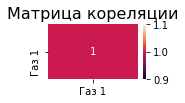

In [11]:
info(df_gas)

**Вывод по газу**

- Пропусков не обнаружено

- Объем газа на партию происход в диапозоне **от 0.008 до 77.99**,с медианой в **11**

- Продувка каждой партии происходит 1 раз

### Анализ данных по измерению температуры 

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


None

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


Количество дубликатов:  0
Количество уникальных партий:  3216


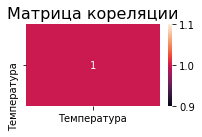

In [12]:
info(df_temp)

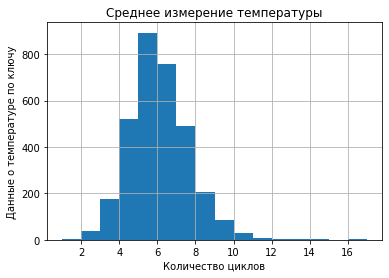

In [13]:
# Среднее измерение температуры на партию
df_temp['key'].value_counts().sort_values().hist(bins=16)
plt.title('Среднее измерение температуры')
plt.xlabel('Количество циклов')
plt.ylabel('Данные о температуре по ключу')
plt.show()

**Вывод по температуре**

- В данных пристувуют пропуски о замерах температуры,следовательно от таких нужно избиваться

- Количество замеров от 1 до 16

- Дубликаты отсутвуют

- Так же на графике видно,что присутвую т замеры с еденичным количеством,такие данные явно помешают нашей работе,так как целевой признак это последний замер

- Температура плавления колбеблиться от 1191 до 1705,медианное 1509

### Анализ данных о проволочных маетриалах(объем и время)

Так данные о проволочных материалов деляться также как и сыпучие,произведем такой же анализ

**Объём**

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Количество дубликатов:  0
Количество уникальных партий:  3081


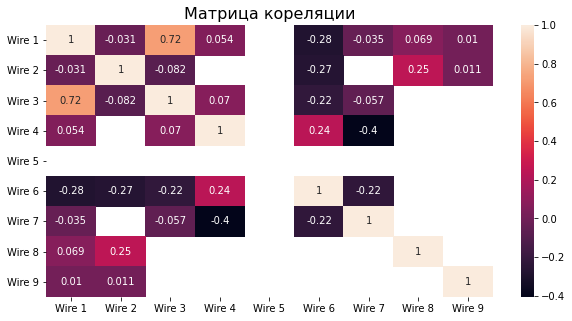

In [14]:
info(df_wire)

In [15]:
# Cреднее добавление материалов в каждую партию 
df_wire.drop('key', axis=1).notna().sum().sum() / df_bulk.shape[0]

1.3883029721955897

**Вывод по объему проволочных материалов**

- Пропуски так же как и сыпучих говорят о том,что в партию не добавлялся данный материал

- Дубликатов не обнаружено

- В среднем добаляется 1.3 ед материала на партию

- Добавка под номером 5 явно использовалась реже чем остальные

- Добавка 8 и 9 также использовалась редка

**Время**

In [16]:
info(df_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


None

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Количество дубликатов:  0
Количество уникальных партий:  3081



<Figure size 720x360 with 0 Axes>

**Общий вывод по проволочным материалам**

- Пропуски так же как и сыпучих говорят о том,что в партию не добавлялся данный материал

- Дубликатов не обнаружено

- В среднем добаляется 1.3 ед материала на партию

- Добавка под номером 5 явно использовалась реже чем остальные

- Добавка 8 и 9 также использовалась редка

### Общий вывод по анализу данных

- Данные загружены и изучены,бибилиотеки импортированы

- Данные о дате и вермени приведены к типу **Datetime**

- Рассчитаны и созданы признаки **Время нагрева**,**Полная мощнасть**,**Энергия нагрева**

- Пропуски в таблице сыпучих и проволочных материалов связаны с отсутвием добалением данных материалов в партию(следует заполнить нулями)

- Пропуски в замерах температуры(их нужно будет удалить)

- Между признаками наблюдается корелляция (где то слабее,где то сильнее)

- Если будем использовать для модели данные о энергии нагрева,то избавимся от мультикорелиарности




**Пока вопросов к заказчику не имею**

## Подготовка данных

### Очистка данных и обработка пропусков

In [17]:
# Пропуски в сыпучих материалах
df_bulk = df_bulk.fillna(0)
# Проверка
df_bulk.isna().sum().sum()

0

In [18]:
# Пропуски в проволочных материалах
df_wire = df_wire.fillna(0)
# Проверка
df_wire.isna().sum().sum()

0

In [19]:
keys_temp = df_temp.groupby(['key']).count()['Температура']
keys_temp = keys_temp[keys_temp > 1].index
df_temp = df_temp[df_temp.key.isin(keys_temp)]
df_temp

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
13921,2499,2019-08-10 13:33:21,1569.0
13922,2499,2019-08-10 13:41:34,1604.0
13923,2499,2019-08-10 13:46:28,1593.0
13924,2499,2019-08-10 13:54:56,1588.0


In [20]:
df_temp.isna().sum()

key             0
Время замера    0
Температура     0
dtype: int64

In [21]:
# Формируем список без аномальных замеров температуры
keys_bad_temp = df_temp[df_temp['Температура'] < 1430]['key'].values
# Табилци без выбросов
df_temp = df_temp.query('key not in @keys_bad_temp')

In [22]:
# Удаление выбросов по реактивной мощности
keys_bad_power = df_arc[df_arc['Реактивная мощность'] < -700]['key'].values[0]
# Таблица без выбросов
df_arc = df_arc[df_arc['key'] != keys_bad_power]

**Вывод**

Данные очищены и обработаны

### Формирование таблицы признаков

1 Таблица замера температуры

-  В таблице замера температуры оставим только первый замер и последний,а так же сформируем новый признак путем нахождения разницы между временем последнего замера температуры и первого(**Общее время нахождения спалава в ковше**)

2 Таблица о нагрева сплава

- Найдем сумарную энергию нагрева для каждой партии

3 Другие таблицы

- Добавим данные о количестве добавленых материалов и газе

4 Сгенерируем некторые признаки

5 Проведем анализ 

**Таблица о замере температуры**

In [23]:
# Агрегация данных о началае и окончании нахождение сплава
df = df_temp.pivot_table(index='key', values=['Время замера'], aggfunc=[min, max])
# Ренейм колонок
df.columns = ['start_time', 'fin_time']
# Проверка
df.head()

,start_time,fin_time
key,,
1,2019-05-03 11:02:04,2019-05-03 11:30:38
2,2019-05-03 11:34:04,2019-05-03 11:55:09
3,2019-05-03 12:06:44,2019-05-03 12:35:57
4,2019-05-03 12:39:27,2019-05-03 12:59:47
5,2019-05-03 13:11:03,2019-05-03 13:36:39


In [24]:
# Присоединеие данных о температуре
df = df.merge(df_temp, left_on='start_time',right_on='Время замера')
# Чистка лишних данных
df = df.drop(['key', 'Время замера'], axis=1)
# Ренейм колонок
df = df.rename(columns = {'Температура': 'start_temp'})
# Поверка
df.head()

,start_time,fin_time,start_temp
0,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0
1,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0
2,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0
3,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0
4,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0


In [25]:
# Присоединеие данных о финанльной температуре
df = df.merge(df_temp, left_on='fin_time',right_on='Время замера')
# Чистка лишних данных
df = df.drop('Время замера', axis=1)
# Ренейм колонок
df = df.rename(columns = {'Температура': 'fin_temp'})
# Проверка
df.head()

,start_time,fin_time,start_temp,key,fin_temp
0,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1,1613.0
1,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,2,1602.0
2,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,3,1599.0
3,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,4,1625.0
4,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,5,1602.0


In [26]:
# Время приготовления партии
df['total_time'] = (df['fin_time'] - df['start_time']).astype('int64') / 1000000000
# Чистка колонок
df = df.drop(['start_time', 'fin_time'], axis=1)
# Проверка
df.head()

,start_temp,key,fin_temp,total_time
0,1571.0,1,1613.0,1714.0
1,1581.0,2,1602.0,1265.0
2,1596.0,3,1599.0,1753.0
3,1601.0,4,1625.0,1220.0
4,1576.0,5,1602.0,1536.0


**Вывод**

Оставили только первый и последний замер,а так же создали новый прижнак общее время в ковше

**Таблица о нагреве сплава**

In [27]:
#Сумарная энергий и время для каждой партии
energy = df_arc[['key', 'Энергия нагрева', 'Время нагрева']].groupby('key').sum()
# Присоединение к таблицу
df = df.merge(energy, on='key')
# Рейнейм колонок
df = df.rename(columns = {'Энергия нагрева': 'total_energy',
                          'Время нагрева': 'heating_time'
                         })
# Проверка
df.head()

,start_temp,key,fin_temp,total_time,total_energy,heating_time
0,1571.0,1,1613.0,1714.0,770.282114,1098.0
1,1581.0,2,1602.0,1265.0,481.760005,811.0
2,1596.0,3,1599.0,1753.0,722.837668,655.0
3,1601.0,4,1625.0,1220.0,683.455597,741.0
4,1576.0,5,1602.0,1536.0,512.169934,869.0


**Вывод**

Данные добалвлены

**Данные о количестве добавленных материалах и газе**

In [28]:
# Добавляем данные о газе
df = df.merge(df_gas, on='key')
# Ренейм колонок
df = df.rename(columns = {'Газ 1': 'gas'})
# Проверка
df.head()

,start_temp,key,fin_temp,total_time,total_energy,heating_time,gas
0,1571.0,1,1613.0,1714.0,770.282114,1098.0,29.749986
1,1581.0,2,1602.0,1265.0,481.760005,811.0,12.555561
2,1596.0,3,1599.0,1753.0,722.837668,655.0,28.554793
3,1601.0,4,1625.0,1220.0,683.455597,741.0,18.841219
4,1576.0,5,1602.0,1536.0,512.169934,869.0,5.413692


In [29]:
# Добавляем данные о сыпучих материалах
df = df.merge(df_bulk, on='key',how='inner')
# Проверка
df.head()

,start_temp,key,fin_temp,total_time,total_energy,heating_time,gas,Bulk 1,Bulk 2,Bulk 3,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1571.0,1,1613.0,1714.0,770.282114,1098.0,29.749986,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,1581.0,2,1602.0,1265.0,481.760005,811.0,12.555561,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,1596.0,3,1599.0,1753.0,722.837668,655.0,28.554793,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,1601.0,4,1625.0,1220.0,683.455597,741.0,18.841219,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,1576.0,5,1602.0,1536.0,512.169934,869.0,5.413692,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [30]:
# Добавлям данные о првоолочных материалах
df = df.merge(df_wire, on='key')
# Проверка
display(df.head())
print('Итоговое количество пропусков: ',df.isna().sum().sum())

,start_temp,key,fin_temp,total_time,total_energy,heating_time,gas,Bulk 1,Bulk 2,Bulk 3,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1571.0,1,1613.0,1714.0,770.282114,1098.0,29.749986,0.0,0.0,0.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1581.0,2,1602.0,1265.0,481.760005,811.0,12.555561,0.0,0.0,0.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1596.0,3,1599.0,1753.0,722.837668,655.0,28.554793,0.0,0.0,0.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1601.0,4,1625.0,1220.0,683.455597,741.0,18.841219,0.0,0.0,0.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1576.0,5,1602.0,1536.0,512.169934,869.0,5.413692,0.0,0.0,0.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Итоговое количество пропусков:  0


**Вывод**

Данные добавлены

### Добавление сгненерированных признаков и их анализ

In [31]:
# Признак сколько энергии потратили за 1 секунду
df['energy_per_second'] = df['total_energy'] / df['total_time']
# Признак времени охлаждения
df['cool_time'] = df['total_time'] - df['heating_time']
# Признак отношение времени нагрева к общему времени
df['scaller_time'] = df['heating_time'] / df['total_time']

**Вывод**

Признаки сформированы и добалены

**Анализ признаков**

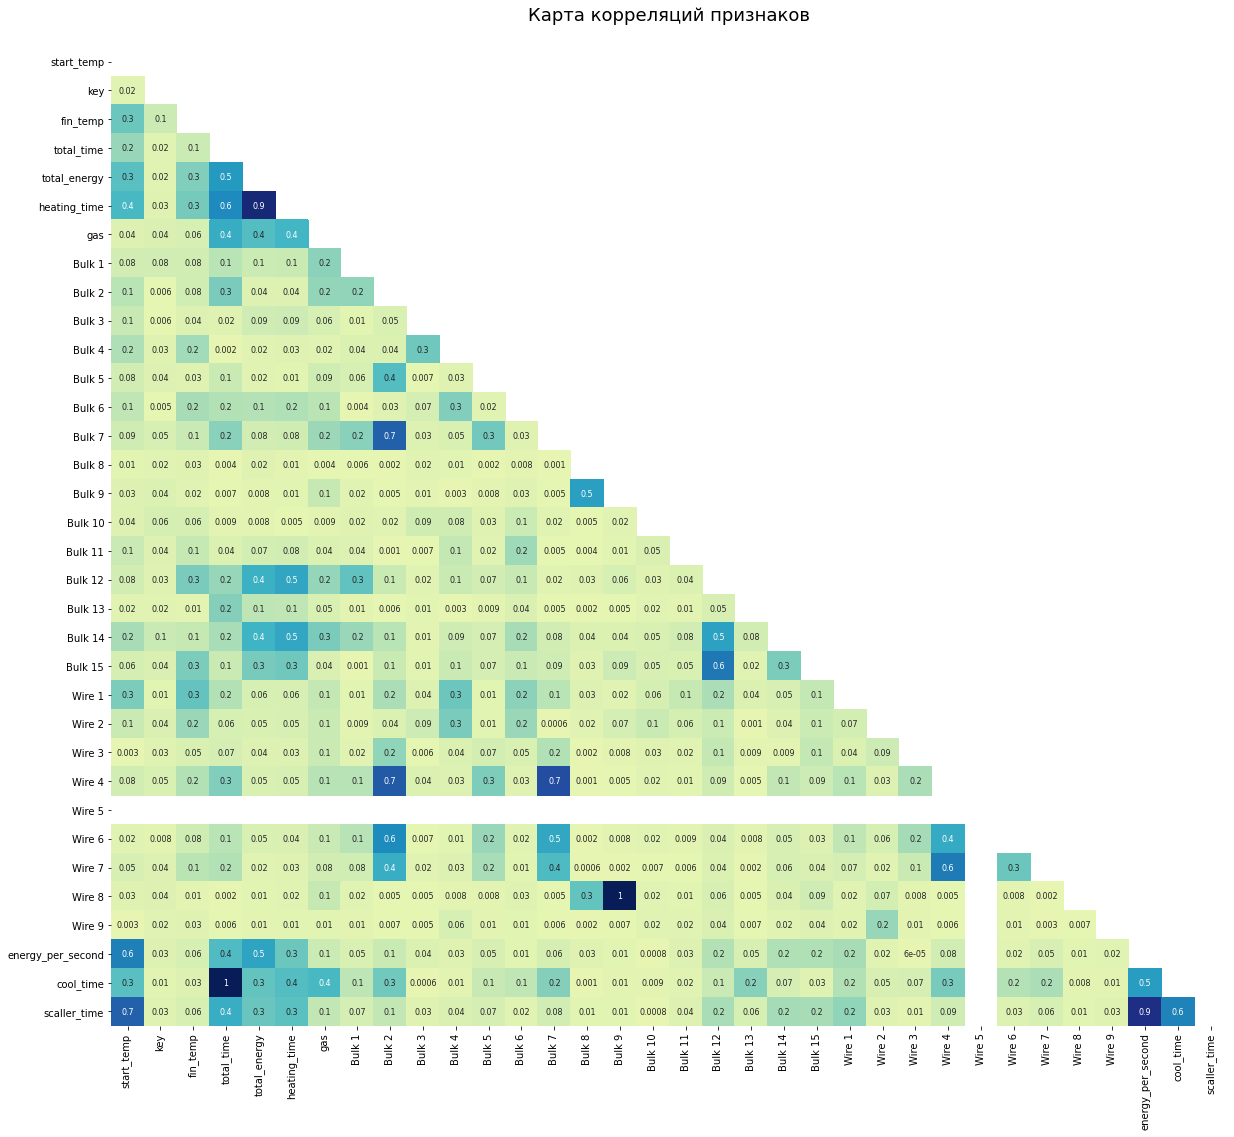

In [32]:
fig = plt.figure(figsize=(20, 18))

sns.heatmap( df.corr().abs(), 
             cmap="YlGnBu", fmt='.1g', 
             cbar=False,
             center=0.4,
             annot=True, 
             annot_kws={'fontsize': 8},             
             mask=np.triu(df.corr()) )

plt.title('Карта корреляций признаков'+ '\n', fontsize=18)
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)

plt.show()

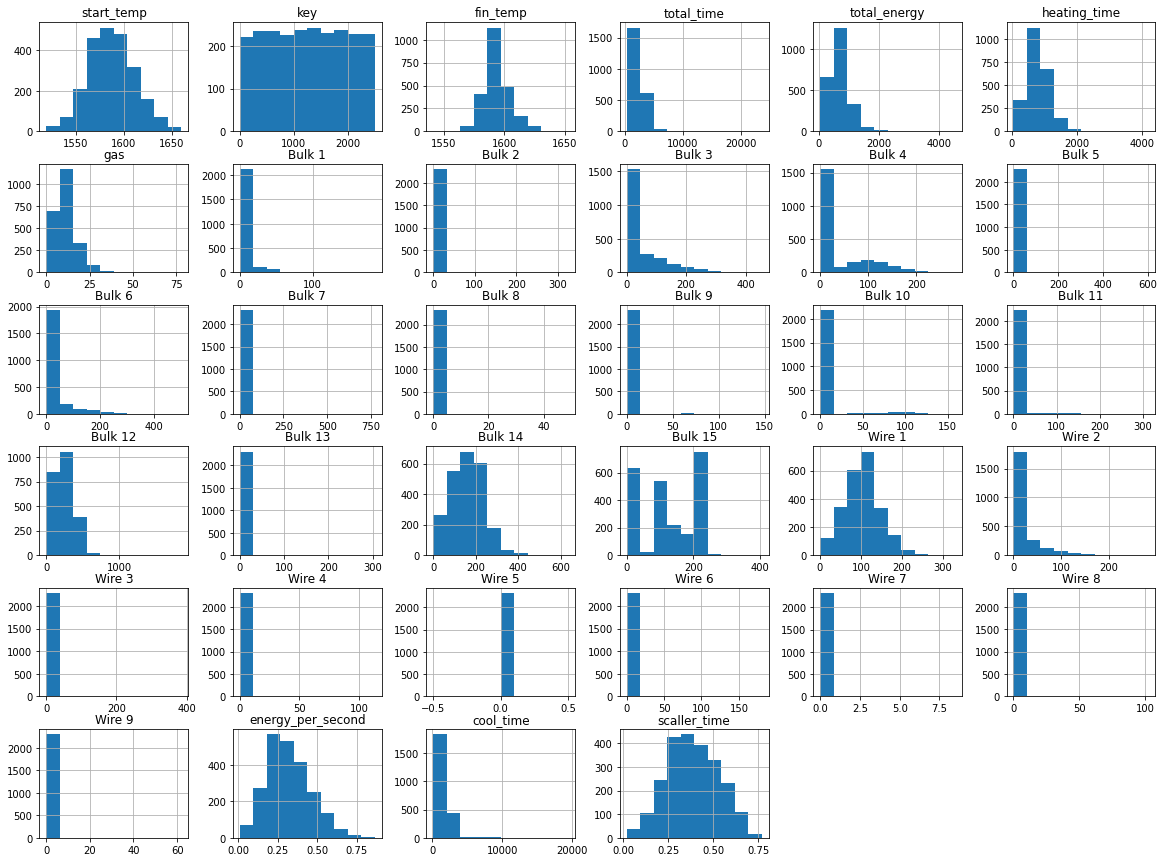

In [33]:
df.hist(figsize=(20,15));

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   start_temp         2324 non-null   float64
 1   key                2324 non-null   int64  
 2   fin_temp           2324 non-null   float64
 3   total_time         2324 non-null   float64
 4   total_energy       2324 non-null   float64
 5   heating_time       2324 non-null   float64
 6   gas                2324 non-null   float64
 7   Bulk 1             2324 non-null   float64
 8   Bulk 2             2324 non-null   float64
 9   Bulk 3             2324 non-null   float64
 10  Bulk 4             2324 non-null   float64
 11  Bulk 5             2324 non-null   float64
 12  Bulk 6             2324 non-null   float64
 13  Bulk 7             2324 non-null   float64
 14  Bulk 8             2324 non-null   float64
 15  Bulk 9             2324 non-null   float64
 16  Bulk 10            2324 

**Вывод**

Из анализа признаков можно сделать следующие выводы

- Между признаками **total_time** и **cool_time** Имеется сильная корреляци,для модели будем использовать тольок один из этих признаков

- Время нагрева входит в формулу расчёта энергии,по этому его использование в модели не входило в планы

-  Между признаками **energy_per_second** и **scaller_time** меется сильная корреляци,для модели будем использовать тольок один из этих признаков **scaller_time**

- Так же можно отметить что **bulk_9** коррелирует с **wire_8**

- Матрица корелляции показывает,что **wire_5** не имеет прямой линейной взаимосвязи с другими признаками

### Формирование выборок

In [35]:
# Признаки
features = df.drop(['key', 'fin_temp', 'heating_time', 'total_time', 'energy_per_second'], axis=1)
# Целевой признак
target  = df['fin_temp']
# Разделение на выборки
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.25, 
                                                                            random_state=40823)

# Проверка
pd.DataFrame(data=[features_train.shape[0], target_train.shape[0],
                   features_test.shape[0],  target_test.shape[0]],
             index=['features_train', 'target_train', 
                    'features_test',  'target_test'],
             columns=['Размер выборки']
            )

,Размер выборки
features_train,1743
target_train,1743
features_test,581
target_test,581


### Общий вывод по разделу  Подготовка данных

В данном разделе успешно произвели

- Очистку данных и обработку пропусков

- Успешно сформировали итоговую таблицу

- Успешно сформировали выборки



## Обучение ML  модели

Рассмотрим 3 классических варианта ML

- Линейная регрессия

- Дерево решений

- Случайны лес

Так как в других проектах CatBoost зарекомендовал себя хорошо,рассмотрим его тоже

- CatBoost

### Линейная регрессия

Применим масштабирование,так как данные модель чувствительная к масштабу признаков

In [36]:
sc = StandardScaler()
features_train_sc = sc.fit_transform(features_train)

In [37]:
lr_model = LinearRegression()
cross_val_score(lr_model, features_train_sc, target_train, n_jobs=-1, scoring='neg_mean_absolute_error').mean()

-6.365230626354955

**Вывод**

Линейная модель,покащывает неплохую метрику

### Дерево решений

- С гипперпараметрами по умолчанию

- С автоподбором

**По умолчанию**


In [38]:
tree_model = DecisionTreeRegressor(random_state=40823)
cross_val_score(tree_model, features_train, target_train, n_jobs=-1,scoring='neg_mean_absolute_error').mean()

-8.619755952969074

**С автоподбором**

In [39]:
%%time
parametrs = { 'max_depth':range(3,50)}

treeCV = GridSearchCV(tree_model, parametrs, scoring='neg_mean_absolute_error', cv=5, )
treeCV.fit(features_train, target_train)
print('Параметры модели:', treeCV.best_params_)
print('Лучший MAE модели:', treeCV.best_score_)

Параметры модели: {'max_depth': 7}
Лучший MAE модели: -7.306223496496767
CPU times: user 3.92 s, sys: 12.9 ms, total: 3.93 s
Wall time: 3.93 s


**Вывод**

Дерево решений дает резудьтат хуже чем линейная регрессия

### Случайный лес

- С гипперпараметрами по умолчанию

- С автоподбором

**По умолчанию**

In [40]:
rf_model = RandomForestRegressor(random_state=40823)
cross_val_score(rf_model, features_train, target_train, n_jobs=-1,scoring='neg_mean_absolute_error').mean()

-6.164566198992197

**С автоподбором**

In [41]:
%%time
parametrs = { 'n_estimators': range (120, 201, 10),
              'max_depth': range (12, 25, 2)}

rfCV = GridSearchCV(rf_model, parametrs, scoring='neg_mean_absolute_error', cv=5)
rfCV.fit(features_train, target_train)
print('Параметры модели:', rfCV.best_params_)
print('Лучший MAE модели:', rfCV.best_score_)

Параметры модели: {'max_depth': 16, 'n_estimators': 140}
Лучший MAE модели: -6.15137644136707
CPU times: user 7min 45s, sys: 1.25 s, total: 7min 46s
Wall time: 7min 50s


**Вывод**

Модель случайного леса показывает лучший результат по метрике MAE ,но занимает много времени


### CatBoost

**По умолчанию**

In [42]:
cat_model = CatBoostRegressor(silent=True, random_state=40823)

cross_val_score(cat_model, features_train, target_train, n_jobs=-1, scoring='neg_mean_absolute_error').mean()

-5.82949540171571

**Вывод**

CatBoost показывает лучший результат,выберем ее как основную модель

### Общий вывод по разделу  Обучение ML модели

В разделе были расммотрены  несколько вариантов моделей машинного обучения с такими  показателями

- Линейная регрессия 6.3

- Дерево решений(автоподбор) 7.3

- Случайный лес 6.1

- CatBoost 5.8

Так как  **Catboost** показал лучшую метрику,в дальнейшем будем использовать его

## Тестирование модели и проверка на адекватность

- Тестированная модели на тестовом наборе данных

- Сравнение полученной модели с константной

- Оценка важности признаков

### Тестирование модели 

In [43]:
best_model = CatBoostRegressor(silent=True, random_state=40823)
best_model.fit(features_train, target_train)
prdictions = best_model.predict(features_test)
mean_absolute_error(target_test, prdictions)

6.1100760139805725

На тестовом наборе данных результат оказался несколько хуже,и это нормально.

### Проверка модели на адекватность

In [44]:
dr = DummyRegressor()
dr.fit(features_train, target_train)
prdictions = dr.predict(features_test)
mean_absolute_error(target_test, prdictions)

8.408635278759489

**Вывод**

- CatBoost 6.1

- Константная модель 8.4

Наша модель показывает результат гораздо лучше чем констатная

### Важность признаков

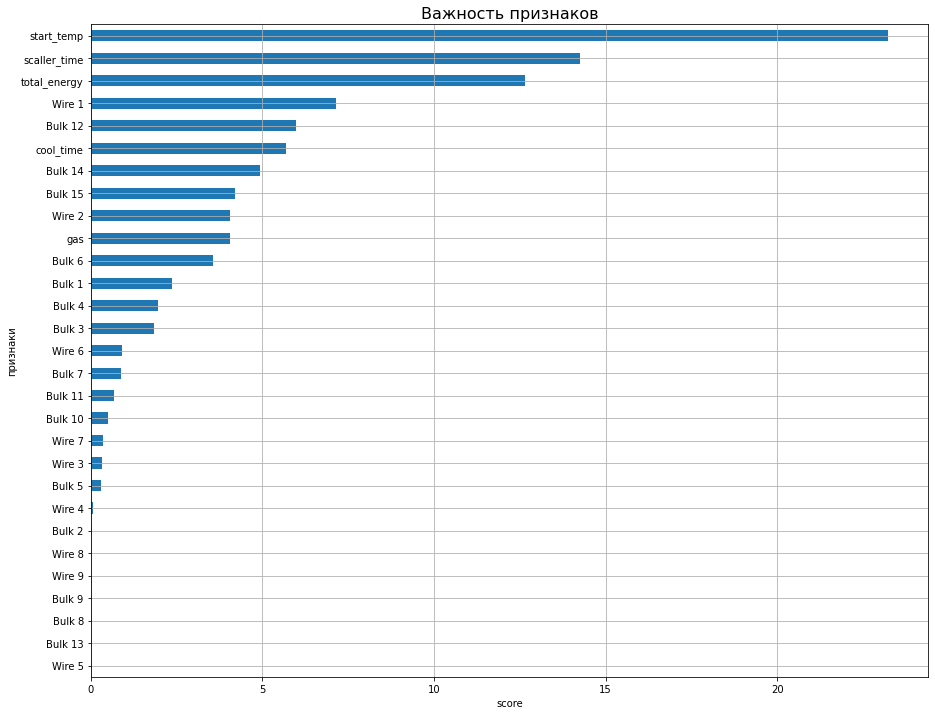

In [45]:
# Выделение признаков
efectiv_score = pd.DataFrame(data={'score': best_model.feature_importances_}, 
                            index=features_train.columns).sort_values(by='score')
# Демонстрация
ax = efectiv_score.plot(kind='barh', grid=True, figsize=(15,12),legend=False);
ax.set_title('Важность признаков', fontsize=16)
ax.set_ylabel('признаки')
ax.set_xlabel('score')
plt.show;

### Общий вывод по разделу Тестирование модели

- Лучшая модель была проверена на тестовом наборе данных где показала метрику 6.1

- Так же наша модель прошла проверку на адекватность в сравнее с констаной,которая показывала 8.4 - наша оказаль лучшей

- Так же проведена оценка важности признаков где
    
    Самым важным оказался признак начальной температуры
    
    Вторым признак отнощения времение к общему нагреву
    
    Сумарная энергия нагрева заняла третье место
    
    Проволочные и сыпучие добавки оказались не атк важны

## Общий вывод о проделанной работе

Задача по оптимизации производственных рассходов на металлургическом заводе была успешно выполнена,путем построения модели машинного обучения

На этапе анализа данны были выполненые следущие действия

- Загрузка данных

- Изучение данных

- Построение графиков

- Определение вбросов,дубликатов

После выполнения шага 1,был исполнен шаг 2, а именно

- Очистка данных

- Формирование итоговой таблицы

- Формирование выборок для обучения модели(тренировачную и тестовую)

В шаге номер 3 мы рассмотрели несколько вариантов машинного обучения

- Линейная регрессия 6.3

- Дерево решений(автоподбор) 7.3

- Случайный лес 6.1

- CatBoost 5.8

Шаг номер 4

Так как **СatBoost** оказался моделью с лучшей метрикой с ним были выполнены следующие действия

- Тестирование модели на тестовом наборе где он показал MAE 6.1

- Сравнение с констаной моделью у которой метрика 8.4(что гораздо хуже нашей)

- А так же определена важность признаков,которые повлияли на обучение модели

## Отчёт по решению

### Cравнение решения и плана, если есть отклонение - объясняем почему

Все пункты а именно

- Первичный анализ данных(Выполнено 6/6)

- Подготовка данных (Выполнено 5/5)

- Обучение модели (Выполнено 5/5)

- Тестирование модели (Выполнено 4/4)

- Общий вывод (Выполнено)

Выполнены успешно,отклонений не выявлено

### Описание трудностей проекта (и как они были решены)

**Проблема 1**

На этапе номер 2 **Подготовка данных** в задании 1,возникла проблема в очистке данных о температуре,никак не мог понять правильный алгоритм действий для выполнения данного задания корректно.Первый вариант получился так скажем "через костыли",что могло в дальнейшем повлиять на решение подобных задач мной крайне негативно.

**Решение**

Помогли ревью моего тим-лида Дмитрия,а так же консультации с сокурсниками,за что благодарен им!

**Проблема 2**

На этапе номер 2 **Подготовка данных** в задании 4.Возникла незначительная проблема в отображении матрицы корреляции признаков.
Данные отображались не читаемо

**Решение**

Помогло ревью моего тим-лида Дмитрия.Для исправления неточностей воспользовался документацией к библиотеке seaborn,что заняло не более 5 минут моего времени!

### Описание ключевых шагов решения

**Шаг 1** Первичный анализ данных

- Импорт библиотек,чтение файлов

- Написание функции(анализа датафреймов) для избежания дублирования кода

- Примение данной функции к данным

- Анализ данных

    О нагреве сплава эктродами
    
    О подаче сыпучих материалов
    
    О продувке сплава газом
    
    О измерении температуры
    
    О подаче проволочных материалов


- Вывод по разделу

**Шаг 2** Подготовка данных

- Заполнение 0 пропусков в таблицах о сыпучих и проволочных материалов

- Удаление данных по ключу в таблице о температуре

- Формирование таблицы признаков

    Таблица о замере температуры(общее время сплава в ковше)
    
    Таблица о нагреве сплава(сумарная энергия для партии)
    
    Таблица о подаче материалов и газе
    
- Генерация дполнительных признаков и добавление их  в финальную таблицу

- Формирование выборок для обучения модели


**Шаг 3** Обучение модели

- Обучение моделей

    Линейная регрессия
    
    Дерево решений
    
    Случайный лес
    
    CatBoost
    
    
- Выбор лучшей модели на основе метрики  МАЕ,лучшей оказалась  CatBoost

**Шаг 4** Тестирование

- Тестирование модели на тестовом наборе данных 

- Сравнение модели  с конкстаной

- Оценка важности признаков

**Шаг 5**

- Написание общего вывода о проделанной работе

### Признаки, которые использовали для обучения и их предобработка

Признаки которые использовались для обучения модели

- start_temp был агрегирован путем нахождения min в данных о  температуре,которые был предварительно очищены от пропусков

- total_energy был сгенерирован путем умножения **полной мощности** на **время нагрева**

- gas исходный признак был добавлен в таблицу по ключу

- cool_time был сгенерирован путем  вычетание из **время приготовления партии**  - **времени нагрева**

- scaller_time был сгенерирова путём деления **времени нагрева** на **время приготовления**

- Данные о сыпучех материалах **Bulk 1** - **Bulk 15**

- Данные о проволочных метриалах **Wire 1** - **Wire 9**

Целевой признак

- fin_temp был агрегирован путем нахождения max в данных о  температуре,которые был предварительно очищены от пропусков

### Полное описание модели (с гиперпараметрами, включая random_state, если использовался)

**Модель**

CatBoostRegressor(silent=True, random_state=40823) -стандарнтные параметры

### Итоговая метрика

Была поставлена задача что бы итоговая метрика на тестовом наборе данных не превышала 6.8

Итоговая метрика модели CatBoost 6.1

### Рекомендации по улучшению решения

В целом я порекомендовал,что бы исходных данных было больше и не пришлось вырезать большую часть из них

Следовательно на более коректных данных можно строить более лучшую модель,а так же я бы проконсультировался с человеком ,который  работает в металлургической сфере,возможно можно было бы сгененировать новые признаки которые повлияли бы на модель

Так же рекомендовал бы рассмотреть другие библиотеки,возможно есть другие методы МЛ для улучшения качества метрики